## TD(0) for Estimation Algorithm

- TD $\; \rightarrow \;$ Temporal Difference
- This is an off-policy algorithm.
- Temporal difference learning is an approach that combines the benefits of both DP (Dynamic Programming) and MC (Monte Carlo), using bootstrapping from DP and the sample-based approach from MC.
- Bootstrapping is the approach where the value of a state is based on the current estimate of the successor state.
- MC is based on starting from a state and sampling the outcomes based on the current policy the agent is following. The value estimates are averages over multiple runs. In other words, the sum over model transition probabilities is replaced by averages.
- TD(0) is a one-step estimate.
- Thus, TD has an advantage over DP as it does not require the model knowledge (transition dynamics function). A TD method has an advantage over MC as TD methods can update the state value at every step; i.e., they can be used in an online setup through which we learn as the situation unfolds without waiting for the end of episode.
- TD(0) is also called one-step TD.

![TD(0) Estimation](./algo_img/tabular_td(0)_estimation.png "TD(0) Estimation")

Let's compare the updates of the Monte Carlo (MC) and Temporal Difference (TD):

- MC Update:

$$V(S_t) \; = \; V(S_t) \, + \, \alpha[G_t - V(S_t)]$$

&nbsp;  

- TD Update:

\begin{align*}
V(S_t) \; & = \; V(S_t) \, + \, \alpha[R_{t+1} + \gamma V(S_{t+1}) \, - \, V(S_t)] \\
& = \; V(S_t) \, + \, \alpha \cdot \delta_t \\
\end{align*}

, where $\; \delta_t \; = \; R_{t+1} + \gamma V(S_{t+1}) \, - \, V(S_t) \; = \;$ TD error

<!-- $$V(S_t) \; = \; V(S_t) \, + \, \alpha[R_{t+1} + \gamma V(S_{t+1}) \, - \, V(S_t)]$$ -->

In [2]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image

In [4]:
class TD0:
    """TD(0) estimation algorithm."""
    def __init__(self, get_possible_actions, strategy, 
                 epsilon=1, alpha=1, gamma=1):
        self._V = defaultdict(lambda: 0)
        self.get_possible_actions = get_possible_actions
        self.epsilon = epsilon
        self.strategy = strategy
        self.alpha = alpha   # learning rate or step size
        self.gamma = gamma   # discount factor


    def _get_V(self, state):
        return self._V[state]


    def set_V(self, state, value):
        self._V[state] = value


    def update(self, state, reward, next_state, done):
        """
        This is the main update function for the TD(0) algorithm.
        Note that this function only contains the update equations, 
        not the entire TD(0) algorithm.
        """
        if not done:
            td_error = reward + self.gamma * self._get_V(next_state) - \
                       self._get_V(state)
        else:
            td_error = reward - self._get_V(state)
        value = self._get_V(state) + self.alpha * td_error
        self.set_V(state, value)


    def max_action(self, state):
        """
        Return the best action for a given state, ie,
        the action in the state that has the highest state value.
        If there are multiple actions with the same state values,
        return a random action from the set of best actions.
        """
        actions = self.get_possible_actions(state)
        best_action = []
        best_state_value = float("-inf")
        for action in actions:
            value = self._get_V(state)
            if value > best_state_value:
                best_action = [action]
                best_state_value = value
            elif value == best_state_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))


    def get_action(self, state):
        """
        Choose an action based on the input strategy.
        """
        return self.strategy(self.epsilon, self.get_possible_actions,
                             state, self.max_action)



In [5]:
def epsilon_greedy_strategy(epsilon, get_possible_actions, state, max_action):
    """
    Epsilon-greedy strategy.

    Choose a random number in the interval [0, 1) with a uniform 
    probability distribution. Use np.random.random() to do this.

    If this random number is less than epsilon, return a random action.
    Otherwise, return the best action for the given state.
    """
    actions = get_possible_actions(state)
    if len(actions) == 0:
        return None
    random_number = np.random.random()
    if random_number < epsilon:
        # exploration
        return np.random.choice(actions)
    else:
        # exploitation
        return max_action(state)
    

In [6]:
def train_agent(env, agent, num_episodes=10_000, t_max=10_000, decay_rate=None):
    """
    This is a generic training function.

    env: gymnasium environment
    agent: SARSA object
    num_episodes: (int) number of episodes to train the agent
    t_max: (int) maximum number of steps per episode
    decay_rate: (float) epsilon decay rate
    """
    episode_rewards = []
    for i in tqdm(range(num_episodes)):
        G = 0
        state, _ = env.reset()
        action = agent.get_action(state)
        for t in range(t_max):
            next_state, reward, done, trunc, _ = env.step(action)
            next_action = agent.get_action(next_state)
            flag = (done or trunc)
            agent.update(state, reward, next_state, flag)
            G += reward
            if flag:
                episode_rewards.append(G)
                if decay_rate is not None:
                    agent.epsilon = agent.epsilon * decay_rate
                break
            state = next_state
            action = next_action
    return np.array(episode_rewards)


In [7]:
def plot_rewards(env_name, rewards, label):
    plt.title(f"Env: {env_name}  Mean Reward: {np.mean(rewards[-20:]):.1f}")
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.show()


### Trying out TD(0) on Cliff Walking environment

In [8]:
Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif")

In [9]:
# create Cliff Walking environment
cw_env = gym.make("CliffWalking-v0")

In [10]:
cw_env.reset()

(36, {'prob': 1})

In [11]:
cw_env.action_space.n

4

In [12]:
cw_env.observation_space.n

48

In [14]:
agent1 = TD0(
    get_possible_actions = lambda s : range(cw_env.action_space.n),
    strategy = epsilon_greedy_strategy,
    epsilon = 0.2,
    alpha = 0.25, 
    gamma = 0.99
)

rewards = train_agent(cw_env, agent1, num_episodes=100, decay_rate=0.99)

100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


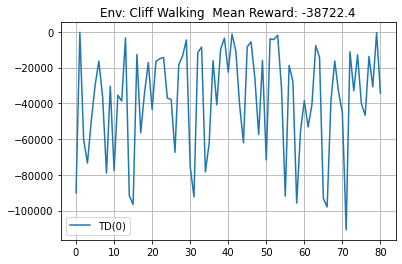

In [15]:
plot_rewards("Cliff Walking", rewards, "TD(0)")

### Trying out TD(0) on Taxi environment

In [16]:
Image(url="https://gymnasium.farama.org/_images/taxi.gif")

In [17]:
t_env = gym.make("Taxi-v3")

In [18]:
t_env.reset()

(321, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [19]:
t_env.action_space.n

6

In [20]:
t_env.observation_space.n

500

In [23]:
agent2 = TD0(
    get_possible_actions = lambda state: range(t_env.action_space.n),
    strategy = epsilon_greedy_strategy, 
    epsilon = 0.2,
    alpha = 0.25, 
    gamma = 0.99
)

rewards = train_agent(t_env, agent2, num_episodes=1000, decay_rate=0.99)

100%|██████████| 1000/1000 [00:13<00:00, 71.54it/s]


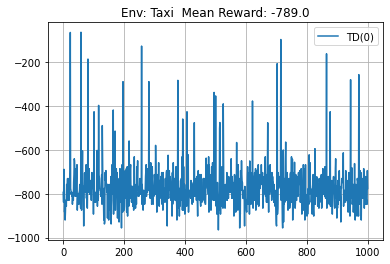

In [24]:
plot_rewards("Taxi", rewards, "TD(0)")